This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import aesara
import aesara.tensor as at
import pymc as pm

import cobra
import os
os.getcwd()

from scipy import stats

from sklearn.model_selection import train_test_split

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve

In [3]:
Teusink_ant ='data/interim/Antimony/flatTeusink.ant' 
data_file = "C:/Users/user/Documents/research/BMCA-pipeline/data/interim/generated_data/flatTeusink/flatTeusink_0.5.csv"
data = pd.read_csv(data_file)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()


8.539696272717074e-10

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
flux = ['v_' + i for i in r.getReactionIds()]

In [5]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:].tolist() if i.values.size > 0]
pt_enz.insert(0, 'WT')

a = data[data[enzymes] != 1].values.flatten()
# a = data[enzymes].values.flatten()
pt_lvls = a[~np.isnan(a)]
pt_lvls = list(pt_lvls)
pt_lvls.insert(0, 1.0)

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [6]:
enzyme_perts = data[[i for i in data.columns if 'e_' in i]]
enzyme_perts = pd.concat([pd.DataFrame(enzyme_perts.iloc[0]).T,enzyme_perts[(enzyme_perts.sum(axis=1) != 18)]])# .transpose()
enzyme_perts.index = enzPtLvls
enzyme_perts.shape

(17, 18)

# Leaving out internal species concentrations

In [7]:
N_SPLITS=6
splits = np.linspace(0,1, N_SPLITS+1)[1:]

In [8]:
crossSections=[]

for i in np.random.randint(1000, size=N_SPLITS): 
    kept, omitted = train_test_split(internal, test_size=0.33, random_state=i)
    holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
    crossSections.append(holey_data)


In [9]:
BIOMD64_0 = BMCA.BMCA(Teusink_ant, crossSections[0])
BIOMD64_1 = BMCA.BMCA(Teusink_ant, crossSections[1])
BIOMD64_2 = BMCA.BMCA(Teusink_ant, crossSections[2])
BIOMD64_3 = BMCA.BMCA(Teusink_ant, crossSections[3])
BIOMD64_4 = BMCA.BMCA(Teusink_ant, crossSections[4])
BIOMD64_5 = BMCA.BMCA(Teusink_ant, crossSections[5])

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

In [11]:
all_BIOMD64=[BIOMD64_0, BIOMD64_1, BIOMD64_2, BIOMD64_3, BIOMD64_4, BIOMD64_5]

## Running ADVI

In [12]:
def calculate_Xss(BMCA_obj):
    
    n_exp = len(BMCA_obj.en)

    product = (BMCA_obj.en*BMCA_obj.v_star)
    N_rep = BMCA_obj.N.reshape((-1, *BMCA_obj.N.shape)).repeat(n_exp, axis=0) # (642, 14, 17)

    def my_func(a): 
        return np.diag(a)
    c = np.apply_along_axis(my_func, 1, product)

    Ex_rep = BMCA_obj.Ex.values.reshape((-1, *BMCA_obj.Ex.shape)).repeat(n_exp, axis=0) # (642, 14, 17)

    As = (N_rep@c@Ex_rep) # (43, 16, 16)

    arr = ((np.ones((len(BMCA_obj.N.T),n_exp)) + (BMCA_obj.Ey @ BMCA_obj.yn.T))).values
    arr = arr.T[:,:, np.newaxis]
    bs = -(N_rep@c) @ arr # (642, 14, 642)

    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()
    
    xn, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)
    
    vn = BMCA_obj.en.values * (np.ones((len(BMCA_obj.v_star), n_exp)) +
                   at.dot(BMCA_obj.Ex, BMCA_obj.xn.T) +
                   at.dot(BMCA_obj.Ey, BMCA_obj.yn.T)).T

    return xn, vn

In [12]:
def run_BayesInf(BMCA_obj):
    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in holey_data.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()
    
    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))

        # trace_prior = pm.sample_prior_predictive(samples=1000)
        
        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))

        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        # supposedly chi_t would be in the order listed in ss tellurium

        pm.Deterministic('chi_t', chi_t)

        e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T) # e_hat?
        y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BMCA_obj.yn.T) # yn?

        xn_ss, vn_ss = calculate_Xss(BMCA_obj)
        pm.Deterministic('xn_ss', xn_ss)


        ######## fitting equation must use chi_t
        chi_clip = aesara.tensor.clip(xn_ss[:, known_chi_inds], -1.5, 1.5)
        chi_obs = pm.Normal('chi_obs', mu=chi_clip, sigma=0.04, observed=BMCA_obj.xn.values.clip(min= -1.5, max= 1.5))
        # v_hat_obs = pm.Normal('v_hat_obs', mu=vn_ss, sigma=1, observed=BMCA_obj.vn)

        N_ITERATIONS = 40000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.2428e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 69,716


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.2196e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.1374e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 87,584


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 92,771


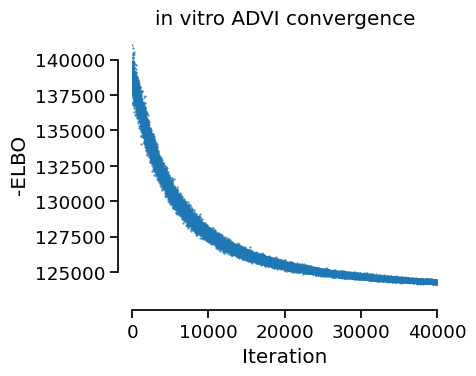

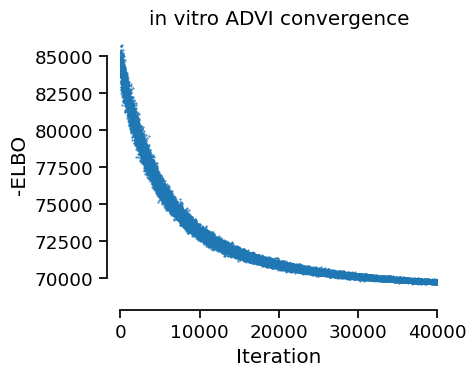

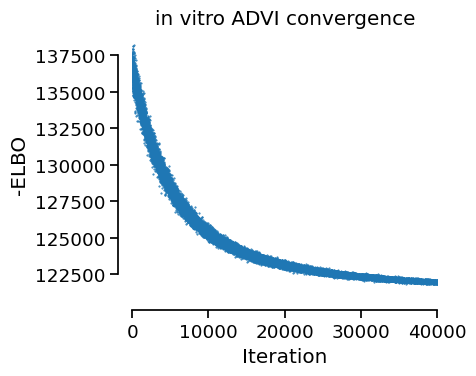

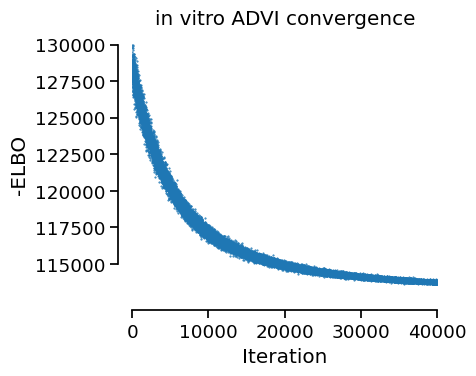

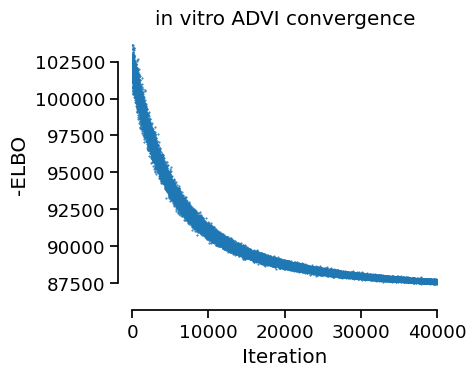

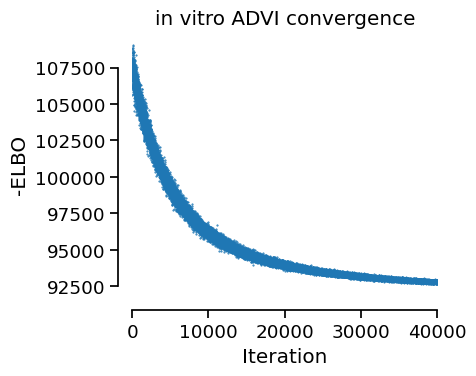

In [13]:
trace_0 = run_BayesInf(BIOMD64_0)
trace_1 = run_BayesInf(BIOMD64_1)
trace_2 = run_BayesInf(BIOMD64_2)
trace_3 = run_BayesInf(BIOMD64_3)
trace_4 = run_BayesInf(BIOMD64_4)
trace_5 = run_BayesInf(BIOMD64_5)


In [11]:
all_traces = [trace_0, trace_1, trace_2, trace_3, trace_4, trace_5]

### Plotting ADVI results

In [12]:
Ex_0 = (trace_0['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_1 = (trace_1['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_2 = (trace_2['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_3 = (trace_3['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_4 = (trace_4['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_5 = (trace_5['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)


In [13]:
all_Exs = [Ex_0, Ex_1 ,Ex_2, Ex_3, Ex_4, Ex_5]

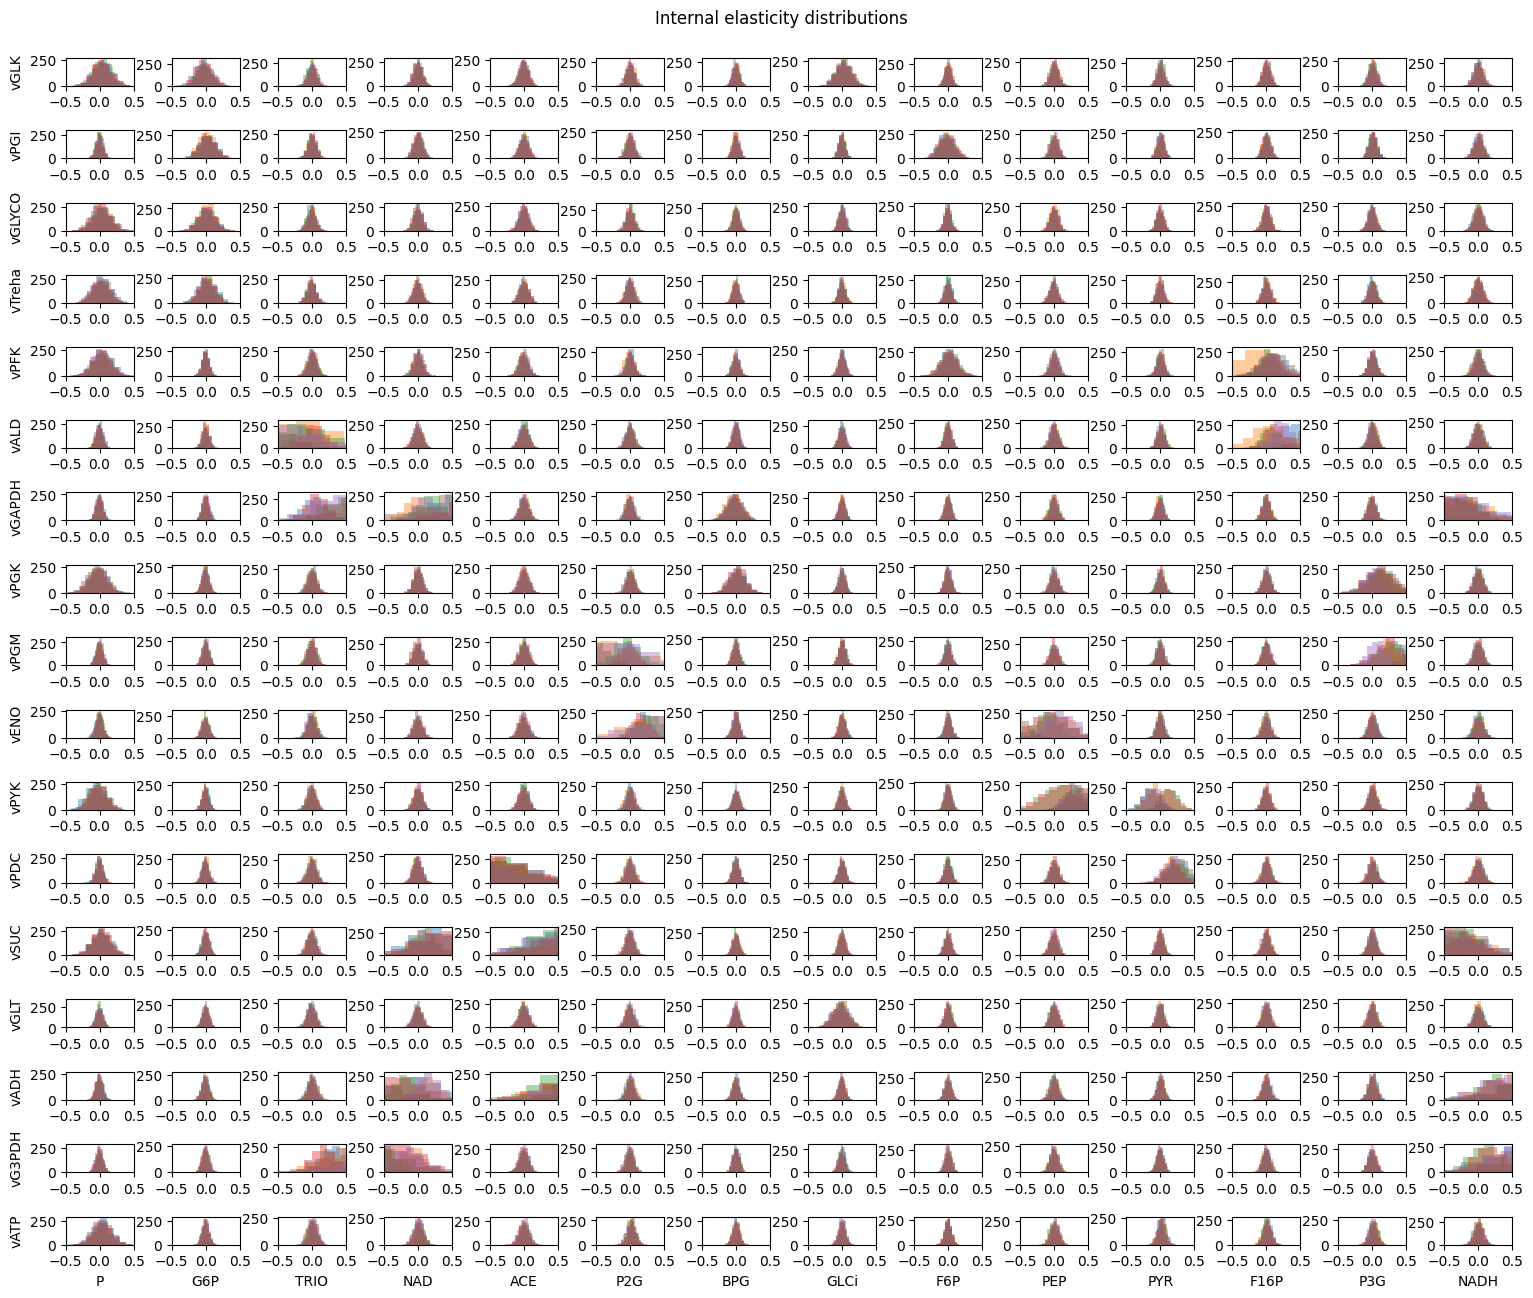

In [14]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for Ex_trace in all_Exs:
  for i in range(17):
    for ii in range(14):
      axs[i,ii].hist(Ex_trace[i,ii,:], alpha=0.4)
      axs[i,ii].set_xlim([-0.5,0.5])

      if ii == 0:
        axs[i,ii].set_ylabel(r.getReactionIds()[i])
      if i == 16: 
        axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

## Plotting MCC and FCC comparisons

In [16]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [25]:
yield_enzyme='vGLK'
fig = plt.figure() 
for i, BIOMD64 in enumerate(all_BIOMD64):
    
    """visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
    visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
    visFCC.columns = r.getReactionIds()
    visFCC.index = r.getReactionIds()"""

    postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, all_Exs[i])  
    postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
    postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
    postFCC.columns = r.getReactionIds()
    postFCC.index = r.getReactionIds()

    #priors = pd.DataFrame(visFCC[yield_enzyme])
    #priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = posteriors.reset_index() # pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
    plt.axhline(y = val,    # Line on y = 0.2
            xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
            xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
            c='red') # To the right

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 14 is different from 17)

<Figure size 640x480 with 0 Axes>

In [27]:
all_Exs[0].shape

(17, 14, 1000)

In [31]:
np.linalg.inv(np.diag(all_BIOMD64[0].x_star)).shape
# np.linalg.inv(np.diag(1/all_BIOMD64[0].v_star))

(9, 9)

In [22]:
def plot_pairwise_FCCs(yield_enzyme):
    fig = plt.figure() 
    for i, BIOMD64 in enumerate(all_BIOMD64):
        
        """visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
        visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
        visFCC.columns = r.getReactionIds()
        visFCC.index = r.getReactionIds()"""

        postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, all_Exs[i])  
        postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
        postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
        postFCC.columns = r.getReactionIds()
        postFCC.index = r.getReactionIds()

        #priors = pd.DataFrame(visFCC[yield_enzyme])
        #priors['distribution'] = ['prior']* len(priors)
        posteriors = pd.DataFrame(postFCC[yield_enzyme])
        posteriors['distribution'] = ['posterior']* len(posteriors)
        paired = posteriors.reset_index() # pd.concat([priors, posteriors]).reset_index()
        pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

        pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

In [ ]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

In [24]:
r.getReactionIds()

['vGLK',
 'vPGI',
 'vGLYCO',
 'vTreha',
 'vPFK',
 'vALD',
 'vGAPDH',
 'vPGK',
 'vPGM',
 'vENO',
 'vPYK',
 'vPDC',
 'vSUC',
 'vGLT',
 'vADH',
 'vG3PDH',
 'vATP']

In [ ]:
fig = plt.figure()

plt.scatter(gtCCC, visCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.ylim([-5,5])
plt.title('Comparing scaled concentration control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), visCCC.to_numpy().flatten())[0]).round(3)))


In [ ]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
fig = plt.figure()

plt.scatter(gtFCC, visFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')
plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), visFCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vADH'].rank(), visFCC.loc['vADH'].rank(), postFCC.loc['vADH'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vADH')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
plt.legend()

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vGLK'].rank(), visFCC.loc['vGLK'].rank(), postFCC.loc['vGLK'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings,vGLK')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vPGI'].rank(), visFCC.loc['vPGI'].rank(), postFCC.loc['vPGI'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vPGI')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

## Pairwise comparison of FCC values

In [ ]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

In [ ]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

## Distribution of FCC Sp. correlation coefficients

In [ ]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


In [ ]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Perturbing enzymes, leaving out flux values 

In [ ]:
kept, omitted = train_test_split(internal, test_size=0.33, random_state=42)

In [ ]:
holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
holey_data.head()

In [ ]:
holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
holey_data.head()

In [ ]:
known_flux_inds = []
omitted_flux_inds = []
for i, v_ in enumerate(flux):
    if v_ in holey_data.columns:
        known_flux_inds.append(i)
    else: 
        omitted_flux_inds.append(i)
flux_inds = np.hstack([known_flux_inds, omitted_flux_inds]).argsort()


## Running ADVI

In [ ]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

In [ ]:
with pymc_model:
    
    e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_t = pm.Normal('chi_t', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [ ]:
with pymc_model:
    likelihood = pm.Deterministic('vn', e_t * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
    
    flux_measured = pm.Normal('flux_measured', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)
    flux_unmeasured = pm.Normal('flux_unmeasured', mu=likelihood, sigma=10, shape=(len(omitted_chi_inds), len(BIOMD64.xn)))

    v_t = at.concatenate([flux_measured, flux_unmeasured], axis=0)[flux_inds, :]
    # supposedly chi_t would be in the order listed in ss tellurium

    pm.Deterministic('v_t', v_t)

In [ ]:
v_t.shape.eval() # 14, 641

In [ ]:
likelihood.shape.eval() # 14, 641
